In [12]:
# imports
import collections
from collections import defaultdict
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorboard_reducer as tbr

## Save tensorboard logs as CSV files

In [13]:
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [14]:
root_path = Path("../experiments/2021_baseline/")

In [19]:
def output_df(df_name, condition):
    global_metric_df = pd.DataFrame()
    params_df = pd.DataFrame()
    for dir_path in root_path.rglob("version_*"):
        csv_path = dir_path / "test_metrics.csv"
        
        if not os.path.exists(str(dir_path)+"/hparams.yaml"):
            continue
        with open(str(dir_path)+"/hparams.yaml") as f:
            conf = yaml.safe_load(f)
            conf.update({"a version id": str(dir_path)[-2:]})
            flatten_conf = flatten(conf)
            flatten_conf = {k:str(v) for k,v in flatten_conf.items() if not k.startswith("data")}
        try:
            events_dict = tbr.load_tb_events(
                [str(dir_path)],
                handle_dup_steps="keep-first"
            )
        except AssertionError:
            continue
        test_metrics = {}
        for k, df in events_dict.items():
            if not condition(k):
                continue
            if "obj_metric" in k or "loss" in k:
                scale_factor = 1
            else:
                scale_factor = 100

            test_metrics[k.rsplit('/')[1].lower()] = df.to_numpy().squeeze()*scale_factor

        metrics_df = pd.DataFrame(test_metrics, index=[conf["experiment_name"]])
        metrics_df.to_csv(dir_path / "test_metrics.csv", float_format='%.2self.labelsself.labelsf')
        global_metric_df = pd.concat([global_metric_df, metrics_df])
        params_df = pd.concat([params_df, pd.DataFrame(flatten_conf, index=[conf["experiment_name"]])])
    global_metric_df = global_metric_df.sort_index()
    params_df = params_df.sort_index()
    global_metric_df.to_csv(root_path / (df_name + "_metrics.csv"), float_format='%.2f')
    params_df.to_csv(root_path / "params.csv")

In [20]:
condition_name = [
("all", lambda k : (k.startswith("Test"))),
("AP", lambda k : (k.startswith("Test")) and "ap" in k),
("AP__micro", lambda k : (k.startswith("Test")) and "ap_micro" in k),
("AP_macro", lambda k : (k.startswith("Test")) and "ap_macro" in k),
("micro", lambda k : (k.startswith("Test")) and "micro" in k),
("macro", lambda k : (k.startswith("Test")) and "macro" in k),
("weak", lambda k : (k.startswith("Test")) and "weak" in k),
("strong", lambda k : (k.startswith("Test")) and "strong" in k),
("monoph", lambda k : (k.startswith("Test")) and "monoph" in k),
("lowpolyph", lambda k : (k.startswith("Test")) and "lowpolyph" in k),
("highpolyph", lambda k : (k.startswith("Test")) and "highpolyph" in k),
("near", lambda k : (k.startswith("Test")) and ("near" in k)),
("far", lambda k : (k.startswith("Test")) and ("far" in k)),
("proximity", lambda k : (k.startswith("Test")) and ("near" in k or "far" in k)),
]

In [21]:
for name, condition in condition_name:
    output_df(name,condition)

In [18]:
pd.DataFrame({k:str(v) for k,v in conf["training"].items()}, index=[0])

NameError: name 'conf' is not defined

## Align downstream tasks evaluation with training metrics

/home/alain/lightning_logs/multi_base/version_2
     loss  alignment loss  uniformity loss  best_val_acc
0   3.851         188.768           -9.914         0.631
1   0.285         190.086           -8.386         0.583
2   0.195         271.159           -9.430         0.592
3   0.127         268.181          -10.431         0.561
4   0.096         160.833          -12.412         0.646
..    ...             ...              ...           ...
95  0.034          55.654             -inf         0.997
96  0.055          62.004             -inf         0.960
97  0.063          59.984             -inf         0.936
98  0.059          50.266             -inf         0.966
99  0.050          78.830             -inf         0.853

[100 rows x 4 columns]
/home/alain/lightning_logs/multi_norelu/version_1
     loss  alignment loss  uniformity loss  best_val_acc
0   3.841         202.758          -10.681         0.646
1   0.292         198.859           -9.038         0.604
2   0.205         285.4

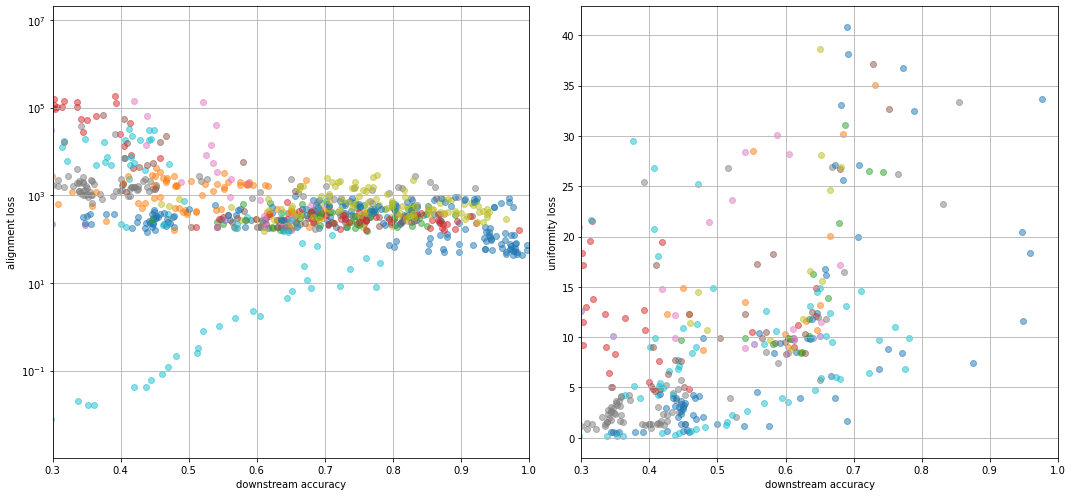

In [44]:
plt.figure(figsize=(15, 7))
for dir_path in root_path.rglob("multi_*/version_*"):
    csv_path = dir_path / "val_metrics.csv"
    if not csv_path.exists():
        continue
    print(dir_path)
    metrics_df = pd.read_csv(csv_path, index_col=0)
    downstream_df = pd.read_csv(dir_path / "checkpoints" / "evaluation_r_instrument_family.csv", index_col=0)
    downstream_acc = downstream_df["best_val_acc"].loc[0:]
    df = pd.concat((metrics_df, downstream_acc), axis=1, join='inner')
    print(df)
    plt.subplot(1, 2, 1)
    plt.scatter(df["best_val_acc"], df["alignment loss"], label=str(dir_path), alpha=0.5)
    plt.subplot(1, 2, 2)
    plt.scatter(df["best_val_acc"], -df["uniformity loss"], label=str(dir_path), alpha=0.5)
for i, key in enumerate(["alignment loss", "uniformity loss"]):
    plt.subplot(1, 2, i+1)
    plt.xlabel("downstream accuracy")
    plt.xlim(0.3, 1)
    plt.ylabel(key)
    if i == 0:
        plt.yscale("log")
    plt.grid(True)
plt.tight_layout()
plt.savefig("plot.pdf")
plt.show()

In [18]:
import sklearn.metrics as M
import numpy as np

In [ ]:
target.sum(axis=0)

array([67, 66, 58, 66, 68, 62, 60, 67, 66, 64])

In [142]:
pred = np.random.rand(9,10)
target = np.random.randint(0,2,(9,10))
ap = M.average_precision_score(target, pred, average='samples')
lrap = M.label_ranking_average_precision_score(target, pred)
f1 = M.f1_score(target, (pred>0.5).astype(int), average='samples')

In [143]:
target

array([[1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 1, 1]])

In [170]:
n_samples = 4
for i in range(1+len(pred)//n_samples):
    t = target[n_samples*i:n_samples*(i+1)]
    p = pred[n_samples*i:n_samples*(i+1)]
    indices = list(range(n_samples*i,n_samples*(i+1)))
    ap = M.average_precision_score(t, p, average='samples')
    lrap = M.label_ranking_average_precision_score(t, p)
    f1 = M.f1_score(t, (p>0.5).astype(int), average='samples')
    prec = M.precision_score(t, (p>0.5).astype(int), average='samples')
    rec = M.recall_score(t, (p>0.5).astype(int), average='samples')
    auc = M.roc_auc_score(t,p,average='samples')
    
    print(ap,lrap,f1,auc)

0.5381316137566138 0.5381316137566137 0.5214285714285715 0.5109523809523809
0.5710041887125221 0.5710041887125221 0.5138888888888888 0.3645833333333333
0.5425925925925926 0.5425925925925926 0.5454545454545454 0.2916666666666667


In [171]:
import torchmetrics
import torch

In [150]:
ap_micro = torchmetrics.AveragePrecision(
    num_classes=10,
    average="micro",
)

In [168]:
ap_micro(torch.from_numpy(pred), torch.from_numpy(target))

tensor(0.4794)

In [169]:
ap_micro.compute()

tensor(0.4766)

In [165]:
ap_micro.reset()

In [166]:
ap_micro.update(torch.from_numpy(pred[:5]), torch.from_numpy(target[:5]))

In [4]:
from IPython.display import Audio
Audio(librosa.load("sample3.flac")[0], rate=22050)

In [5]:
import soundfile as sf

In [6]:
sf._libname

'/linkhome/rech/genltc01/ufg11lw/.conda/envs/jupyter/lib/libsndfile.so.1'